In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
sep = '/'

- Load raw data

In [2]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)

In [3]:
def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)




Loading Data:	2018-05-03_02 (done)



In [4]:
spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



In [23]:
cluster_to_plot = good_cluster_numbers[12]
num_spikes_for_averaging = 10000
num_channels = 32
num_samples_per_waveform = 60

In [24]:
spike_times_0 = spike_times[spike_clusters==cluster_to_plot]
spike_times_final = spike_times_0.ravel()

In [25]:
df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
df.head()

,cluster,spike_times
0,125,129
1,132,254
2,118,698
3,132,836
4,23,913


In [26]:
df = df.loc[df['cluster'].isin(good_cluster_numbers)]

In [27]:
extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]

In [28]:
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))

In [29]:
threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels))

In [30]:
for spike in np.arange(0,num_spikes_for_averaging):
    start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
    end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data
    
    waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
    threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

mean_waveform = np.mean(threeD_matrix, axis=0)

In [31]:
cols = [''.join(['Chan_', str(num)]) for num in range(1, 33)]

In [32]:
waveform_per_channel_df = pd.DataFrame(mean_waveform, columns=cols)

## Todo
    - Take max of each column
    - Take min of each column
    - Take absolute value of the min and max per column
    - Find column that has the highest distance
    - Plot that column

In [33]:
maxes = waveform_per_channel_df.apply(np.max, axis=0)

In [34]:
lab = maxes.idxmax()

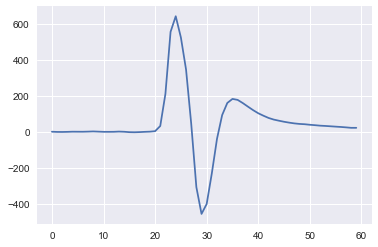

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
correct_chan = waveform_per_channel_df.loc[:, lab]
correct_chan.plot()
plt.show()

In [36]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)

## Calculate half spike width
    - Convert x axis from samples to seconds or ms
    - Find the peak y value, store the x value (time) as a variable
    - Write an algorythm that detect when the y value stops decreases with decreasing x values
    - Return the x value at which this occurs
    - Calculate the distance in time between these points

In [58]:
max_peak_time = correct_chan.idxmax()[0]
min_peak_time = correct_chan.idxmin()[0]

In [59]:
counter = np.arange(0, min_peak_time, 1)

from_min_to_end = np.arange(min_peak_time, 60, 1)



In [60]:
baseline = []
return_point = []

for time_point in counter:
    if correct_chan.loc[time_point][0] > (correct_chan.loc[max_peak_time][0]/20):
        baseline.append(time_point)
    else:
        pass

for return_time_point in from_min_to_end:
    if np.absolute(np.absolute(correct_chan.loc[return_time_point][0]) - correct_chan.loc[baseline[-1]][0])<(correct_chan.loc[baseline[-1]][0]/2):
        return_point.append(return_time_point)
    else:
        pass


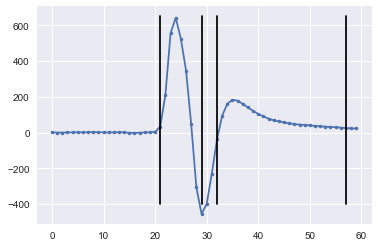

In [63]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[0], np.linspace(-400, 650, 5), 'k')
#plt.plot(np.ones(5)*max_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*return_point[-1], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

## To be use when the first return point is not very accurate due to not having enough data points

Assume the line connecting between the (presumably) return point and the next data point can be expressed by the linear equation:

y=ax+b

where y is our y value
      x is time
      
we can find the values of a and be by solving the simultaneous equation using the x and y values of the two above data points:

y1 = ax1 + b 
y2 = ax2 + b 

=> a = (x1-x2)/(y1-y2)
   b = y1-ax1
   
now we can estimate the baseline-return time:

baseline-return time = (baseline-y value -b)/a

In [64]:
a = (correct_chan.loc[return_point[0]+1][0]-correct_chan.loc[return_point[0]][0])
b = correct_chan.loc[return_point[0]][0]-a*(return_point[0])

estimated_return_time = (correct_chan.loc[baseline[-1]][0]-b)/a
estimated_return_time


32.64108774166136

Now plot again

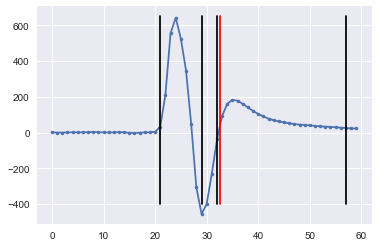

In [69]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[0], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')

#The initial baseline return point
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

#new estimated baseline return point shown in red
plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')

plt.plot(np.ones(5)*return_point[-1], np.linspace(-400, 650, 5), 'k')

## Calculate the full spike wide (to troff)
    - Find the minimum value
    - x value
    - calculate the diffference in time between the baseline and the mimum point

In [72]:
Base_to_max = (correct_chan.idxmax()[0]-baseline[0])/30
Base_to_min = (correct_chan.idxmin()[0]-baseline[0])/30
Base_to_return_to_base = (return_point[0]-baseline[0])/30

#If use estimated baseline return
#Base_to_return_to_base = (estimated_return_time - baseline[-1])/30

amplitude_base_to_peak = correct_chan.max()[0] - correct_chan.loc[baseline[0]][0]
amplitude_min_to_max = correct_chan.max()[0] - correct_chan.min()[0]
amplitude_base_to_min = correct_chan.min()[0] - correct_chan.loc[baseline[0]][0]

In [88]:
if (correct_chan.max()[0] - correct_chan.loc[baseline[-1]][0])<50 or ((correct_chan.max()[0] - correct_chan.loc[baseline[-1]][0])>50 and correct_chan.idxmax()[0]>correct_chan.idxmin()[0]):
    Base_to_min = (correct_chan.idxmin()[0]-baseline[-1])/30
    Base_to_return_to_base = (return_point[0]-baseline[0])/30
    amplitude_base_to_min = correct_chan.min()[0] - correct_chan.loc[baseline[0]][0]
    data_table = pd.DataFrame({'Base to min (ms)':Base_to_min, 
                               'Return to base (ms)': Base_to_return_to_base, 
                               'Amplitude base-min (V)':amplitude_base_to_min,
                              'spike_category': 'down_up'},
                              index=[0])
else:
    Base_to_max = (correct_chan.idxmax()[0]-baseline[0])/30
    Base_to_min = (correct_chan.idxmin()[0]-baseline[0])/30
    Base_to_return_to_base = (return_point[0]-baseline[0])/30
    amplitude_base_to_peak = correct_chan.max()[0] - correct_chan.loc[baseline[0]][0]
    amplitude_min_to_max = correct_chan.max()[0] - correct_chan.min()[0]
    data_table = pd.DataFrame({'Base to max (ms)':Base_to_max, 
                               'Base to min (ms)':Base_to_min, 
                               'Return to base (ms)': Base_to_return_to_base, 
                               'Amplitude base-max (V)':amplitude_base_to_peak, 
                               'Amplitude min-max (V)':amplitude_min_to_max,
                              'spike_category': 'up_down_up'}, index=[0])
    
    
data_table   

,Amplitude base-max (V),Amplitude min-max (V),Base to max (ms),Base to min (ms),Return to base (ms),spike_category
0,608.8534,1096.5435,0.1,0.266667,0.366667,up_down_up


In [ ]:
pd.concat([df_1, df_2 ....], how='outer', axis=1)